# Programming for Data Science and Artificial Intelligence

## 10. Neural Network from Scratch

Readings: Chapter 1-2, Seth Weidman (2020), Deep Learning from Scratch

Github link: https://github.com/SethHWeidman/DLFS_code

### Foundations

Let's first consider the following neural network

![](figures/neuralnet1.png)

In [16]:
import numpy as np

np.random.seed(42)

#suppose we have datasets of three features, with three samples
X = np.random.randn(3, 3)

#let say our y has two output
W = np.random.randn(3, 2)

print("X:")
print(X)

print("W: ")
print(W)

X:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]]
W: 
[[ 0.54256004 -0.46341769]
 [-0.46572975  0.24196227]
 [-1.91328024 -1.72491783]]


### 1. The dot product

Dot product is simply an efficient way of multiplying each x with their corresponding weights.  The end result of dot product will be the predicted y

$$ \nu(X, W) = X * W = \begin{bmatrix}
x_{11} * w_{11} + x_{12} * w_{21} + x_{13} * w_{31} &
x_{11} * w_{12} + x_{12} * w_{22} + x_{13} * w_{32}
\\
x_{21} * w_{11} + x_{22} * w_{21} + x_{23} * w_{31} &
x_{21} * w_{12} + x_{22} * w_{22} + x_{23} * w_{32}
\\
x_{31} * w_{11} + x_{32} * w_{21} + x_{33} * w_{31} &
x_{31} * w_{12} + x_{32} * w_{22} + x_{33} * w_{32}
\end{bmatrix} = 
\begin{bmatrix}
XW_{11} &
XW_{12}
\\
XW_{21} &
XW_{22}
\\
XW_{31} &
XW_{32}
\end{bmatrix}
$$

In [17]:
print("X @ W")

assert X.shape[1] == W.shape[0]

N = X @ W
print(N)  #N is in shape X.shape[0], W.shape[1]

X @ W
[[-0.90531863 -1.38085038]
 [ 1.38335695 -0.35858825]
 [ 1.39763665  0.26365983]]


### 2. The activation function

Sometimes, the predicted y may not be in the form we need.  Activation function is a neaty way of mapping some values to a particular range we want.

Important characteristics of the activation function (commonly called sigma in general) is that it should be differentiable.  Why?  Because differentiable function will allow us to use descent algorithms to find the optimal w.

Text(0, 0.5, 'output')

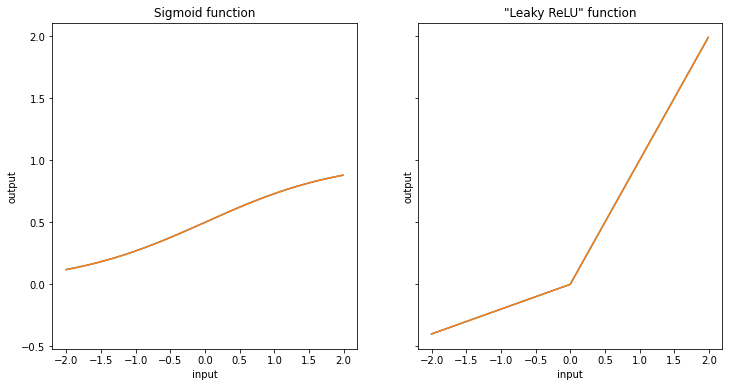

In [18]:
from numpy import ndarray
import matplotlib.pyplot as plt

def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-x))

def leaky_relu(x: ndarray) -> ndarray:
    return np.maximum(0.2 * x, x)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))  # 1 Row, 2 Cols

input_range = np.arange(-2, 2, 0.01)
ax[0].plot(input_range, sigmoid(input_range))
ax[0].plot(input_range, sigmoid(input_range))
ax[0].set_title('Sigmoid function')
ax[0].set_xlabel('input')
ax[0].set_ylabel('output')

ax[1].plot(input_range, leaky_relu(input_range))
ax[1].plot(input_range, leaky_relu(input_range))
ax[1].set_title('"Leaky ReLU" function')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output')


$$ 
\sigma(X * W) = \begin{bmatrix}
\sigma(x_{11} * w_{11} + x_{12} * w_{21} + x_{13} * w_{31}) &
\sigma(x_{11} * w_{12} + x_{12} * w_{22} + x_{13} * w_{32})
\\
\sigma(x_{21} * w_{11} + x_{22} * w_{21} + x_{23} * w_{31}) &
\sigma(x_{21} * w_{12} + x_{22} * w_{22} + x_{23} * w_{32})
\\
\sigma(x_{31} * w_{11} + x_{32} * w_{21} + x_{33} * w_{31}) &
\sigma(x_{31} * w_{12} + x_{32} * w_{22} + x_{33} * w_{32})
\end{bmatrix} = 
\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix}
$$

In [19]:
sigma = sigmoid

S = sigma(N)
print("S: ")
print(S)

S: 
[[0.28795874 0.20087246]
 [0.7995296  0.41130135]
 [0.80180859 0.56553575]]


### 3. The Lambda function

Why do we need to sum all elements?

First, we know that we need to use descent algorithms to find the optimum value.  Let's say we want to find the gradient of S with respect to X and W.  What does gradient of one matrix with respect to another matrix mean?   Yes, it's actually difficult to think in that way.

Instead, for "gradient" to be well-defined, we need to sum (or perform any aggregations) into a single number so that "how much will changing each element of X affect the output".

Thus, we need a third lambda function that simply takes everything and sums up.  (Note again that there are other possible aggregation methods)

$$ L = \Lambda(\sigma(X * W)) = \Lambda(\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix}) =  \sigma(XW_{11}) + \sigma(XW_{12}) + \sigma(XW_{21}) + \sigma(XW_{22}) + \sigma(XW_{31}) + \sigma(XW_{32})
$$

In [20]:
L = np.sum(S)

print(L)

3.067006496510426


### 4. Chain rule / Backpropagation

The question now is if we want to perform gradient descent, we must find derivatives.   Finding derivatives are easy, but how do we find derivatives of L with respect to X and W, when L is a result of series of transformations?

We can simply use the chain rule in Math.


First, let's define what is derivative, which can be expressed in a limit form as 

$$ \frac{df}{dx}(a) = 
\lim_{\Delta \to 0} \frac{{f \left( {a + \Delta } \right) - f\left( a - \Delta \right)}}{2 * \Delta } $$

In [21]:
from typing import Callable

#takes in ndarray and produces an ndarray
def deriv(func: Callable[[ndarray], ndarray],
          input_: ndarray,
          diff: float = 0.001) -> ndarray:
    '''
    Evaluates the derivative of a function "func" at every element in the "input_" array.
    '''
    return (func(input_ + diff) - func(input_ - diff)) / (2 * diff)

Second, let's learn about the chain rule, which is a mathematical theorem that lets us compute the derivatives of composite funtions.    Mathematically, the theorem states that for a given value x, 

$$ \frac{df_2}{dx}(x) = \frac{df_2}{du}(f_1(x)) * \frac{df_1}{dx}(x) $$

A pictorial explaination is given as follows:

Given the following composite function:

![](figures/chainrule1.png)

To find the gradient of y in respect to X, is simply the product of the gradients

![](figures/chainrule2.png)

In [22]:
from typing import List

# A Function takes in an ndarray as an argument and produces an ndarray
Array_Function = Callable[[ndarray], ndarray]

# A Chain is a list of functions
Chain = List[Array_Function]

In [23]:
def chain_length_2(chain: Chain,
                   x: ndarray) -> ndarray:
    '''
    Evaluates two functions in a row, in a "Chain".
    '''
    assert len(chain) == 2, "Length of input 'chain' should be 2"

    f1 = chain[0]
    f2 = chain[1]

    return f2(f1(x))

In [24]:
def chain_deriv_2(chain: Chain,
                  input_range: ndarray) -> ndarray:
    '''
    Uses the chain rule to compute the derivative of two nested functions:
    (f2(f1(x))' = f2'(f1(x)) * f1'(x)
    '''

    assert len(chain) == 2, "This function requires 'Chain' objects of length 2"

    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"

    f1 = chain[0]
    f2 = chain[1]

    # df1/dx
    f1_of_x = f1(input_range)

    # df1/du
    df1dx = deriv(f1, input_range)

    # df2/du(f1(x))
    df2du = deriv(f2, f1(input_range))

    # Multiplying these quantities together at each point
    return df1dx * df2du

In [25]:
def plot_chain(ax,
               chain: Chain, 
               input_range: ndarray) -> None:
   
    assert input_range.ndim == 1, "Function requires a 1 dimensional ndarray as input_range"

    output_range = chain_length_2(chain, input_range)
    ax.plot(input_range, output_range)
    
def plot_chain_deriv(ax,
                     chain: Chain,
                     input_range: ndarray) -> ndarray:
    output_range = chain_deriv_2(chain, input_range)
    ax.plot(input_range, output_range)

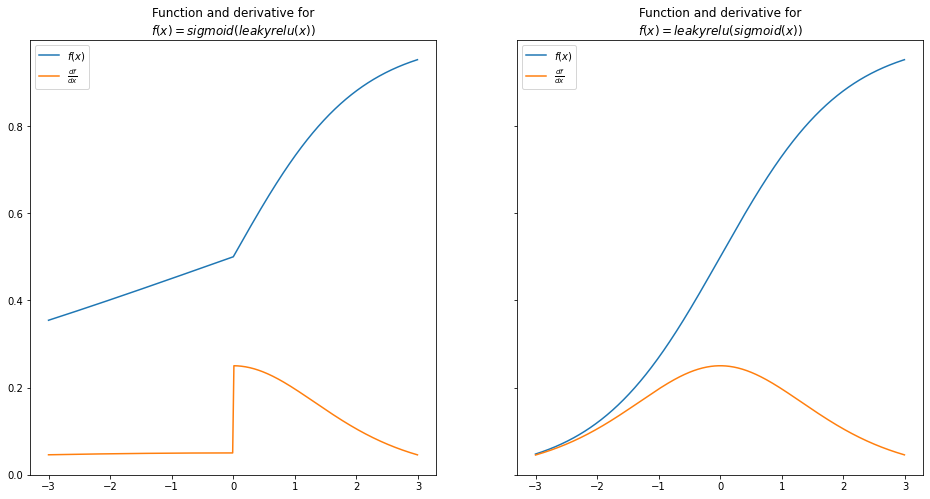

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))  # 2 Rows, 1 Col

chain_1 = [leaky_relu, sigmoid]
chain_2 = [sigmoid, leaky_relu]

PLOT_RANGE = np.arange(-3, 3, 0.01)
plot_chain(ax[0], chain_1, PLOT_RANGE)
plot_chain_deriv(ax[0], chain_1, PLOT_RANGE)

ax[0].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[0].set_title("Function and derivative for\n$f(x) = sigmoid(leakyrelu(x))$")

plot_chain(ax[1], chain_2, PLOT_RANGE)
plot_chain_deriv(ax[1], chain_2, PLOT_RANGE)
ax[1].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[1].set_title("Function and derivative for\n$f(x) = leakyrelu(sigmoid(x))$");

Now let's go back to our example.  Find the derivatives of L in respect to X and W can be written as follows:

$$ \frac{\partial \Lambda}{\partial u}(X) = 
\frac{\partial \nu}{\partial X}(X, W) *
\frac{\partial \sigma}{\partial u}(N) *
\frac{\partial \Lambda}{\partial u}(S) $$

Last term is the easiest.  We want to know how much L will increase if each element of S increases.  Since L is the sum of all the element of S, this derivative is simply:

$$ \frac{\partial \Lambda}{\partial u}(S) = \begin{bmatrix}
1 & 1\\
1 & 1\\
1 & 1
\end{bmatrix} $$

Second term is also easy.  It is simply:

$$ \frac{\partial \sigma}{\partial u}(N) = \begin{bmatrix}
\frac{\partial \sigma}{\partial u}(XW_{11}) &
\frac{\partial \sigma}{\partial u}(XW_{12}) \\
\frac{\partial \sigma}{\partial u}(XW_{21}) &
\frac{\partial \sigma}{\partial u}(XW_{22}) \\
\frac{\partial \sigma}{\partial u}(XW_{31}) &
\frac{\partial \sigma}{\partial u}(XW_{32})
\end{bmatrix} $$

Now, we can already find the product of second and last term which is:

$$ \frac{\partial \Lambda}{\partial u}(N) = 
\frac{\partial \Lambda}{\partial u}(S) *
\frac{\partial \sigma}{\partial u}(N) =  \begin{bmatrix}
\frac{\partial \sigma}{\partial u}(XW_{11}) &
\frac{\partial \sigma}{\partial u}(XW_{12}) \\
\frac{\partial \sigma}{\partial u}(XW_{21}) &
\frac{\partial \sigma}{\partial u}(XW_{22}) \\
\frac{\partial \sigma}{\partial u}(XW_{31}) &
\frac{\partial \sigma}{\partial u}(XW_{32})
\end{bmatrix} $$

How about $$ \frac{\partial \nu}{\partial X}(X, W) $$ and $$ \frac{\partial \nu}{\partial W}(X, W) $$

This is asking how much increasing each element of X will increase each element of N.  Same for W on N.  Since N is simply a function of dot product of X and W, the gradient is magically simple as follows:

$$ \frac{\partial \nu}{\partial X}(X, W) = W^T $$

$$ \frac{\partial \nu}{\partial W}(X, W) = X^T $$

Thus, 

$$ \frac{\partial \Lambda}{\partial u}(X) = 
\frac{\partial \Lambda}{\partial u}(S) * 
\frac{\partial \sigma}{\partial u}(N) *
W^T
$$

$$ 
\frac{\partial \Lambda}{\partial u}(W) = X^T *
\frac{\partial \Lambda}{\partial u}(S) * 
\frac{\partial \sigma}{\partial u}(N) $$

The math looks confusing, but the code is actually pretty simple

In [27]:
def forward(X: ndarray,W: ndarray) -> float:
    assert X.shape[1] == W.shape[0]

    N = np.dot(X, W)
    S = sigma(N)
    L = np.sum(S)

    return L

In [28]:
def forward_backward(X: ndarray,W: ndarray) -> float:
    assert X.shape[1] == W.shape[0]

    N = np.dot(X, W)
    S = sigma(N)
    L = np.sum(S)
    
    # dLdS - just 1s
    dLdS = np.ones_like(S)

    # dSdN
    dSdN = deriv(sigma, N)
    
    # dLdN
    dLdN = dLdS * dSdN

    # dNdX
    dNdX = W.T
    #dNdW = X.T

    # dLdX
    dLdX = np.dot(dSdN, dNdX)
    #dldW = np.dot(dNdW, dSdN)

    return dLdX

In [29]:
print("X:")
print(X)

print("L:")
print(round(forward(X, W), 4))
print("dLdX:")
print(forward_backward(X, W))

X:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]]
L:
3.067
dLdX:
[[ 0.03685663 -0.05665209 -0.6691846 ]
 [-0.02524588 -0.01606117 -0.72432314]
 [-0.027645   -0.0145585  -0.72786339]]


In [30]:
X1 = X.copy()

#if we increase X by 0.001
X1[0, 0] += 0.001

#then L should increase by 0.001 x 0.0369.   If we divide by 0.001, we should see the 0.0369
round((forward(X1, W) - forward(X, W))/0.001, 4)

0.0369